# AI for Market Trend Analysis  
## Predicting Apple Stock Returns Using LSTM Networks

### Problem Definition
This project aims to predict next-day returns of Apple Inc. (AAPL) stock using historical price information and external explanatory variables. Financial markets are known to be noisy and weakly predictable; therefore, the objective is not to perfectly forecast prices, but to identify whether deep learning models can extract modest, non-random predictive signals from sequential financial data.

### Motivation
Apple is one of the most actively traded and widely followed equities globally. Understanding its short-term return dynamics has practical relevance for portfolio management, risk assessment, and algorithmic trading research. This project explores whether recurrent neural networks (LSTMs) can capture temporal dependencies in stock returns when combined with peer-firm, market-wide, and macroeconomic information.

### Selected Track
**AI for Market Trend Analysis**

## Data Sources & Description

Daily financial data were collected from Yahoo Finance & Kaggle for the following assets:

- **Target Stock**: Apple Inc. (AAPL) - Kaggle
- **Peer Firms**: Amazon, Google, Meta, Netflix - Kaggle
- **Market Index**: S&P 500 - Kaggle
- **Macroeconomic Indicators**: Gold prices (USD) - Kaggle , Crude oil prices - Yahoo finance

The dataset spans multiple years at a daily frequency. All price series were aligned by date to ensure consistency across assets. Adjusted closing prices were used to account for corporate actions such as stock splits and dividends.


## Data Preparation & Feature Engineering

Raw price series are non-stationary and unsuitable for most machine learning models. Therefore, all price variables were transformed into **log returns**, which are commonly used in financial modeling due to their stationarity and interpretability.

Key preparation steps included:
- Conversion of prices to daily log returns
- Alignment of firm-level and macroeconomic variables
- Removal of observations with missing peer-firm data
- Construction of lagged return features
- Scaling of input variables prior to neural network training

# Importing and Cleaning Data ( Ran into some problem here with introducing new columns and hence I am now going to rerun the entire thing from the next Section)

In [ ]:
import pandas as pd
import numpy as np


In [ ]:
amazon = pd.read_csv("/content/AMAZON_daily.csv")
apple = pd.read_csv("/content/APPLE_daily.csv")
google = pd.read_csv("/content/GOOGLE_daily.csv")
meta = pd.read_csv("/content/META_daily.csv")
netflix = pd.read_csv("/content/NETFLIX_daily.csv")


In [ ]:
print(amazon.head())

amazon.info()


         Date      Open      High       Low     Close   Adj Close    Volume
0  15-05-1997  0.121875  0.125000  0.096354  0.097917  1443120000  0.097917
1  16-05-1997  0.098438  0.098958  0.085417  0.086458   294000000  0.086458
2  19-05-1997  0.088021  0.088542  0.081250  0.085417   122136000  0.085417
3  20-05-1997  0.086458  0.087500  0.081771  0.081771   109344000  0.081771
4  21-05-1997  0.081771  0.082292  0.068750  0.071354   377064000  0.071354
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7191 entries, 0 to 7190
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       7191 non-null   object 
 1   Open       7191 non-null   float64
 2   High       7191 non-null   float64
 3   Low        7191 non-null   float64
 4   Close      7191 non-null   float64
 5   Adj Close  7191 non-null   int64  
 6   Volume     7191 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 393.4+ KB


In [ ]:
for df in [amazon, apple, google, meta, netflix]:
    df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')


ValueError: time data "1980-12-12" doesn't match format "%d-%m-%Y", at position 0. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

In [ ]:
amazon['Company'] = 'Amazon'
apple['Company'] = 'Apple'
google['Company'] = 'Google'
meta['Company'] = 'Meta'
netflix['Company'] = 'Netflix'


In [ ]:
daily_data = pd.concat(

    [amazon, apple, google, meta, netflix],

    axis=0,

    ignore_index=True
)


In [ ]:
daily_data = daily_data.sort_values(['Company', 'Date'])


In [ ]:
print(daily_data.head())
print(daily_data.tail())
print(daily_data.info())

                  Date      Open      High       Low     Close   Adj Close  \
0  1997-05-15 00:00:00  0.121875  0.125000  0.096354  0.097917  1443120000   
1  1997-05-16 00:00:00  0.098438  0.098958  0.085417  0.086458   294000000   
2  1997-05-19 00:00:00  0.088021  0.088542  0.081250  0.085417   122136000   
3  1997-05-20 00:00:00  0.086458  0.087500  0.081771  0.081771   109344000   
4  1997-05-21 00:00:00  0.081771  0.082292  0.068750  0.071354   377064000   

     Volume Company  
0  0.097917  Amazon  
1  0.086458  Amazon  
2  0.085417  Amazon  
3  0.081771  Amazon  
4  0.071354  Amazon  
             Date       Open       High        Low      Close  Adj Close  \
33236  2025-12-08  99.870003  99.889999  95.300003  96.790001  100906300   
33237  2025-12-09  97.029999  97.239998  95.449997  96.709999   51745600   
33238  2025-12-10  96.739998  96.970001  92.349998  92.709999   74129300   
33239  2025-12-11  93.900002  94.820000  92.760002  94.089996   43949000   
33240  2025-12-12  

In [ ]:
daily_data.isna().sum()

In [ ]:
daily_data = daily_data.drop_duplicates()


In [ ]:
amazon_weekly = pd.read_csv("/content/APPLE_weekly.csv")
amazon_weekly['Date'] = pd.to_datetime(amazon_weekly['Date'])


In [ ]:
amazon_daily_only = daily_data[daily_data['Company'] == 'Amazon']

amazon_daily_weekly = (
    amazon_daily_only
    .set_index('Date')
    .resample('W')
    .last()
    .reset_index()
)


In [ ]:
amazon_weekly['Year'] = amazon_weekly['Date'].dt.year
amazon_weekly['Week'] = amazon_weekly['Date'].dt.isocalendar().week

amazon_daily_weekly['Year'] = amazon_daily_weekly['Date'].dt.year
amazon_daily_weekly['Week'] = amazon_daily_weekly['Date'].dt.isocalendar().week



In [ ]:
comparison = pd.merge(
    amazon_weekly[['Year', 'Week', 'Close']],
    amazon_daily_weekly[['Year', 'Week', 'Close']],
    on=['Year', 'Week'],
    suffixes=('_weekly_file', '_derived_from_daily')
)


In [ ]:
comparison.head()


In [ ]:
comparison.shape


In [ ]:
daily_data.reset_index(drop=True, inplace=True)
daily_data.to_csv("Clean_Daily_Stock_Data.csv", index=False)


In [ ]:
gold = pd.read_csv("/content/Daily.csv")


In [ ]:
gold = gold[['Date', 'USD']]


In [ ]:
gold.rename(columns={'USD': 'Gold_USD'}, inplace=True)


In [ ]:
gold['Date'] = pd.to_datetime(gold['Date'], dayfirst=False)


In [ ]:
gold.info()
gold.isna().sum()


In [ ]:
daily_data = pd.merge(
    daily_data,
    gold,
    on='Date',
    how='left'
)


In [ ]:
print(daily_data[['Date', 'Company', 'Close', 'Gold_USD']].head(10))
daily_data.isna().sum()  # Ensure no missing values


In [ ]:
# Sort by date (required for forward fill)
daily_data = daily_data.sort_values('Date')

# Forward-fill missing Gold prices
daily_data['Gold_USD'] = daily_data['Gold_USD'].ffill()


In [ ]:
daily_data.isna().sum()


In [ ]:
daily_data.to_csv('/content/Clean_Daily_Stock_Data_with_Gold.csv', index=False)

In [ ]:
import yfinance as yf

sp500 = yf.download("^GSPC", start="1927-12-30")
sp500.head()


/tmp/ipython-input-1813914509.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500 = yf.download("^GSPC", start="1927-12-30")
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,
1927-12-30,17.660000,17.660000,17.660000,17.660000,0
1928-01-03,17.760000,17.760000,17.760000,17.760000,0
1928-01-04,17.719999,17.719999,17.719999,17.719999,0
1928-01-05,17.549999,17.549999,17.549999,17.549999,0
1928-01-06,17.660000,17.660000,17.660000,17.660000,0


In [ ]:
sp500.to_csv("/content/SP500_Daily.csv")


In [ ]:
crude_oil = yf.download("CL=F", start="1983-01-01")

crude_oil.head()

/tmp/ipython-input-4099272434.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  crude_oil = yf.download("CL=F", start="1983-01-01")
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,CL=F,CL=F,CL=F,CL=F,CL=F
Date,,,,,
2000-08-23,32.049999,32.799999,31.950001,31.950001,79385
2000-08-24,31.629999,32.240002,31.400000,31.900000,72978
2000-08-25,32.049999,32.099998,31.320000,31.700001,44601
2000-08-28,32.869999,32.919998,31.860001,32.040001,46770
2000-08-29,32.720001,33.029999,32.560001,32.820000,49131


In [ ]:
crude_oil.to_csv("/content/Crude_Oil_Daily.csv", index=False)

In [ ]:
crude_oil = crude_oil.reset_index()


In [ ]:
crude_oil.columns = [
    col[0] if isinstance(col, tuple) else col
    for col in crude_oil.columns
]


In [ ]:
crude_oil = crude_oil[['Date', 'Close']]
crude_oil.rename(columns={'Close': 'Crude_Oil_Price'}, inplace=True)


In [ ]:
crude_oil = crude_oil.sort_values('Date')
crude_oil['Crude_Oil_Price'] = crude_oil['Crude_Oil_Price'].ffill()


In [ ]:
crude_oil.head()


,Date,Crude_Oil_Price
0,2000-08-23,32.049999
1,2000-08-24,31.629999
2,2000-08-25,32.049999
3,2000-08-28,32.869999
4,2000-08-29,32.720001


In [ ]:
daily_data = pd.read_csv('/content/Clean_Daily_Stock_Data_with_Gold.csv')


In [ ]:
crude_oil.columns


Index(['Date', 'Crude_Oil_Price'], dtype='object')

In [ ]:
daily_data['Date'] = pd.to_datetime(daily_data['Date'], errors='coerce')
crude_oil['Date'] = pd.to_datetime(crude_oil['Date'], errors='coerce')


In [ ]:
daily_data['Date'].dtype, crude_oil['Date'].dtype


(dtype('<M8[ns]'), dtype('<M8[ns]'))

In [ ]:
daily_data = pd.merge(
    daily_data,
    crude_oil,
    on='Date',
    how='left'
)

daily_data['Crude_Oil_Price'] = daily_data['Crude_Oil_Price'].ffill()


In [ ]:
daily_data.isna().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0
Company,0
Gold_USD,0
Crude_Oil_Price,5804


In [ ]:
daily_data = daily_data.dropna(subset=['Crude_Oil_Price'])


In [ ]:
daily_data.isna().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0
Company,0
Gold_USD,0
Crude_Oil_Price,0


In [ ]:
## Exploratory Data Analysis

Exploratory analysis was conducted on the return series to understand their statistical properties. Stock returns exhibit high volatility, heavy tails, and are centered around zero, consistent with known stylized facts of financial markets.

Visual inspection highlights:
- Significant noise in daily returns
- Higher volatility for individual stocks compared to the market index
- Weak but observable co-movement between Apple and broader market returns


In [ ]:
daily_data

,Date,Open,High,Low,Close,Adj Close,Volume,Company,Gold_USD,Crude_Oil_Price
5804,2000-08-23,0.771801,0.821005,0.765709,0.814444,236863200,0.814444,Apple,273.2,32.049999
5805,2000-08-23,1.818750,1.975000,1.750000,1.940625,94426000,1.940625,Amazon,273.2,32.049999
5806,2000-08-24,0.819833,0.849122,0.800386,0.841389,310766400,0.841389,Apple,272.6,31.629999
5807,2000-08-24,1.978125,2.025000,1.940625,1.968750,94380000,1.968750,Amazon,272.6,31.629999
5808,2000-08-25,1.956250,2.003125,1.928125,1.996875,54172000,1.996875,Amazon,273.7,32.049999
...,...,...,...,...,...,...,...,...,...,...
33236,2025-12-12,230.020004,230.080002,225.119995,226.190002,28000162,226.190002,Amazon,"1,960.6",57.439999
33237,2025-12-12,277.795013,279.220001,276.820007,278.279999,38360082,278.279999,Apple,"1,960.6",57.439999
33238,2025-12-12,650.210022,711.000000,638.609985,644.229980,10143568,644.229980,Meta,"1,960.6",57.439999
33239,2025-12-12,314.809998,316.130005,306.959991,310.519989,20315069,310.519989,Google,"1,960.6",57.439999


In [ ]:
sp500 = sp500.reset_index()


In [ ]:
sp500.columns = [
    col[0] if isinstance(col, tuple) else col
    for col in sp500.columns
]


In [ ]:
sp500 = sp500[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]


In [ ]:
sp500.rename(
    columns={
        'Open': 'SP500_Open',
        'High': 'SP500_High',
        'Low': 'SP500_Low',
        'Close': 'SP500_Close',
        'Volume': 'SP500_Volume'
    },
    inplace=True
)


In [ ]:
sp500['Date'] = pd.to_datetime(sp500['Date'])
daily_data['Date'] = pd.to_datetime(daily_data['Date'])


In [ ]:
sp500['Date'].dtype, daily_data['Date'].dtype


(dtype('<M8[ns]'), dtype('<M8[ns]'))

In [ ]:
sp500 = sp500.sort_values('Date')

sp_cols = [
    'SP500_Open', 'SP500_High',
    'SP500_Low', 'SP500_Close',
    'SP500_Volume'
]

sp500[sp_cols] = sp500[sp_cols].ffill()


In [ ]:
daily_data = pd.merge(
    daily_data,
    sp500,
    on='Date',
    how='left'
)


In [ ]:
daily_data.isna().sum()


,0
Date,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0
Company,0
Gold_USD,0
Crude_Oil_Price,0


In [ ]:
daily_data.to_csv(
    '/content/Final_Market_Dataset.csv',
    index=False
)


In [ ]:
daily_data.head()
daily_data['Adj Close'] = daily_data['Adj Close'].astype(float)
daily_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27437 entries, 0 to 27436
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             27437 non-null  datetime64[ns]
 1   Open             27437 non-null  float64       
 2   High             27437 non-null  float64       
 3   Low              27437 non-null  float64       
 4   Close            27437 non-null  float64       
 5   Adj Close        27437 non-null  float64       
 6   Volume           27437 non-null  float64       
 7   Company          27437 non-null  object        
 8   Gold_USD         27437 non-null  object        
 9   Crude_Oil_Price  27437 non-null  float64       
 10  SP500_Open       27437 non-null  float64       
 11  SP500_High       27437 non-null  float64       
 12  SP500_Low        27437 non-null  float64       
 13  SP500_Close      27437 non-null  float64       
 14  SP500_Volume     27437 non-null  int64

In [ ]:
daily_data.describe()


,Date,Open,High,Low,Close,Adj Close,Volume,Crude_Oil_Price,SP500_Open,SP500_High,SP500_Low,SP500_Close,SP500_Volume
count,27437,27437.000000,27437.000000,27437.000000,27437.000000,2.743700e+04,27437.000000,27437.000000,27437.000000,27437.000000,27437.000000,27437.000000,2.743700e+04
mean,2014-08-09 06:39:14.688923648,65.338861,66.119583,64.551609,65.353945,1.703090e+08,65.353945,66.965613,2459.415819,2473.061691,2444.757788,2459.852668,3.652449e+09
min,2000-08-23 00:00:00,0.037786,0.041071,0.034643,0.037286,1.584340e+05,0.037286,-37.630001,679.280029,695.270020,666.789978,676.530029,0.000000e+00
25%,2008-11-20 00:00:00,3.955000,4.039500,3.890000,3.959500,4.093800e+07,3.959500,49.619999,1273.479980,1281.000000,1265.640015,1273.829956,2.968340e+09
50%,2015-01-16 00:00:00,22.203123,22.466357,21.950001,22.234585,8.691400e+07,22.234585,66.120003,1989.660034,1997.650024,1979.060059,1989.630005,3.652610e+09
75%,2020-06-30 00:00:00,93.404198,94.580002,92.231427,93.473999,1.858740e+08,93.473999,83.260002,3271.639893,3285.780029,3247.770020,3273.399902,4.342650e+09
max,2025-12-12 00:00:00,790.616435,795.712965,780.293380,789.467163,7.421641e+09,789.467163,145.289993,6910.950195,6920.339844,6870.729980,6901.000000,1.145623e+10
std,NaN,101.517102,102.721551,100.242189,101.496836,2.481619e+08,101.496836,23.292212,1488.722064,1495.807049,1481.039353,1488.998196,1.380193e+09


In [ ]:
daily_data['Stock_Return'] = (
    daily_data.groupby('Company')['Adj Close']
    .pct_change()
)


In [ ]:
daily_data['Market_Return'] = daily_data['SP500_Close'].pct_change()

daily_data['Excess_Return'] = (
    daily_data['Stock_Return'] - daily_data['Market_Return']
)


In [ ]:
daily_data['Stock_Return_Lag1'] = (
    daily_data.groupby('Company')['Stock_Return'].shift(1)
)


In [ ]:
daily_data

,Date,Open,High,Low,Close,Adj Close,Volume,Company,Gold_USD,Crude_Oil_Price,SP500_Open,SP500_High,SP500_Low,SP500_Close,SP500_Volume,Stock_Return,Market_Return,Excess_Return,Stock_Return_Lag1
0,2000-08-23,0.771801,0.821005,0.765709,0.814444,236863200.0,0.814444,Apple,273.2,32.049999,1498.130005,1507.199951,1489.520020,1505.969971,871000000,NaN,NaN,NaN,NaN
1,2000-08-23,1.818750,1.975000,1.750000,1.940625,94426000.0,1.940625,Amazon,273.2,32.049999,1498.130005,1507.199951,1489.520020,1505.969971,871000000,NaN,0.000000,NaN,NaN
2,2000-08-24,0.819833,0.849122,0.800386,0.841389,310766400.0,0.841389,Apple,272.6,31.629999,1505.969971,1511.160034,1501.250000,1508.310059,837100000,0.312008,0.001554,0.310454,NaN
3,2000-08-24,1.978125,2.025000,1.940625,1.968750,94380000.0,1.968750,Amazon,272.6,31.629999,1505.969971,1511.160034,1501.250000,1508.310059,837100000,-0.000487,0.000000,-0.000487,NaN
4,2000-08-25,1.956250,2.003125,1.928125,1.996875,54172000.0,1.996875,Amazon,273.7,32.049999,1508.310059,1513.469971,1505.089966,1506.449951,685600000,-0.426022,-0.001233,-0.424789,-0.000487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27432,2025-12-12,230.020004,230.080002,225.119995,226.190002,28000162.0,226.190002,Amazon,"1,960.6",57.439999,6886.850098,6899.850098,6801.790039,6827.410156,4910160000,-0.008830,-0.010664,0.001834,-0.271743
27433,2025-12-12,277.795013,279.220001,276.820007,278.279999,38360082.0,278.279999,Apple,"1,960.6",57.439999,6886.850098,6899.850098,6801.790039,6827.410156,4910160000,0.153756,0.000000,0.153756,0.006347
27434,2025-12-12,650.210022,711.000000,638.609985,644.229980,10143568.0,644.229980,Meta,"1,960.6",57.439999,6886.850098,6899.850098,6801.790039,6827.410156,4910160000,-0.223114,0.000000,-0.223114,-0.227912
27435,2025-12-12,314.809998,316.130005,306.959991,310.519989,20315069.0,310.519989,Google,"1,960.6",57.439999,6886.850098,6899.850098,6801.790039,6827.410156,4910160000,-0.216001,0.000000,-0.216001,0.138268


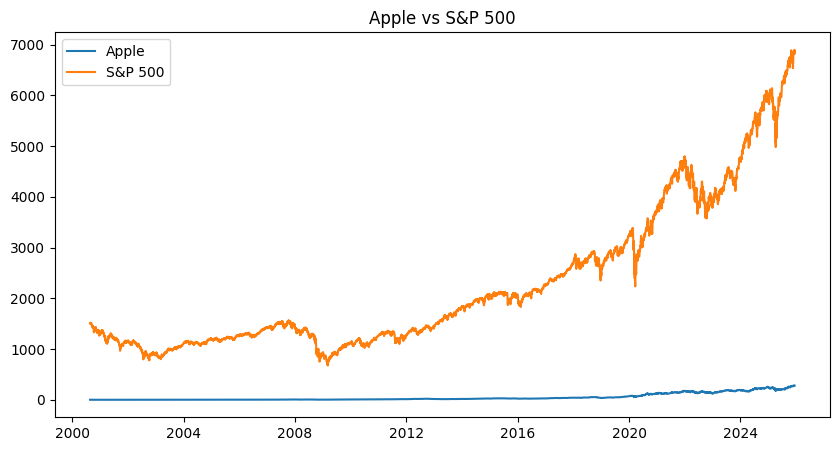

In [ ]:
import matplotlib.pyplot as plt

apple_data = daily_data[daily_data['Company'] == 'Apple']

plt.figure(figsize=(10,5))
plt.plot(apple_data['Date'], apple_data['Close'], label='Apple')
plt.plot(apple_data['Date'], apple_data['SP500_Close'], label='S&P 500')
plt.legend()
plt.title('Apple vs S&P 500')
plt.show()


# Continued cleaning dataset and building features

In [77]:
import pandas as pd
import numpy as np

# Load base dataset
base_data = pd.read_csv('/content/Final_Market_Dataset.csv')

# inspect first
base_data.head()


,Date,Open,High,Low,Close,Adj Close,Volume,Company,Gold_USD,Crude_Oil_Price,SP500_Open,SP500_High,SP500_Low,SP500_Close,SP500_Volume
0,2000-08-23,0.771801,0.821005,0.765709,0.814444,236863200,0.814444,Apple,273.2,32.049999,1498.130005,1507.199951,1489.520020,1505.969971,871000000
1,2000-08-23,1.818750,1.975000,1.750000,1.940625,94426000,1.940625,Amazon,273.2,32.049999,1498.130005,1507.199951,1489.520020,1505.969971,871000000
2,2000-08-24,0.819833,0.849122,0.800386,0.841389,310766400,0.841389,Apple,272.6,31.629999,1505.969971,1511.160034,1501.250000,1508.310059,837100000
3,2000-08-24,1.978125,2.025000,1.940625,1.968750,94380000,1.968750,Amazon,272.6,31.629999,1505.969971,1511.160034,1501.250000,1508.310059,837100000
4,2000-08-25,1.956250,2.003125,1.928125,1.996875,54172000,1.996875,Amazon,273.7,32.049999,1508.310059,1513.469971,1505.089966,1506.449951,685600000


In [78]:
base_data['Date'] = pd.to_datetime(base_data['Date'])

In [79]:
base_data['Adj Close'] = base_data['Adj Close'].astype(float)

In [80]:
base_data['Gold_USD'] = (
    base_data['Gold_USD']
    .astype(str)
    .str.replace(',', '')
    .astype(float)
)

In [81]:
base_data.dtypes

,0
Date,datetime64[ns]
Open,float64
High,float64
Low,float64
Close,float64
Adj Close,float64
Volume,float64
Company,object
Gold_USD,float64
Crude_Oil_Price,float64


In [82]:
data = base_data.copy()

In [83]:
data = data.sort_values(['Company', 'Date']).reset_index(drop=True)

In [84]:
data['Stock_Return'] = (
    data
    .groupby('Company')['Adj Close']
    .pct_change()
)

In [89]:
data['Stock_Log_Return'] = (
    data.groupby('Company')['Adj Close']
    .transform(lambda x: np.log(x / x.shift(1)))
)


In [86]:
data['Market_Return'] = data['SP500_Close'].pct_change()
data['Market_Log_Return'] = np.log(
    data['SP500_Close'] / data['SP500_Close'].shift(1)
)


In [87]:
data['Gold_Return'] = data['Gold_USD'].pct_change()
data['Gold_Log_Return'] = np.log(
    data['Gold_USD'] / data['Gold_USD'].shift(1)
)


In [88]:
data['Crude_Return'] = data['Crude_Oil_Price'].pct_change()
data['Crude_Log_Return'] = np.log(
    data['Crude_Oil_Price'] / data['Crude_Oil_Price'].shift(1)
)


/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [90]:
data['Excess_Return'] = data['Stock_Return'] - data['Market_Return']
data['Excess_Log_Return'] = (
    data['Stock_Log_Return'] - data['Market_Log_Return']
)


In [91]:
data['Stock_Return_Lag1'] = (
    data.groupby('Company')['Stock_Return'].shift(1)
)

data['Stock_Log_Return_Lag1'] = (
    data.groupby('Company')['Stock_Log_Return'].shift(1)
)

In [92]:
data = data.dropna(
    subset=[
        'Stock_Return',
        'Market_Return',
        'Gold_Return',
        'Crude_Return',
        'Stock_Return_Lag1'
    ]
)


In [95]:
data = data.dropna(
    subset=[
        'Stock_Log_Return',
        'Market_Log_Return',
        'Gold_Log_Return',
        'Crude_Log_Return'
    ]
)


In [96]:
data.isna().sum()


,0
Date,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0
Company,0
Gold_USD,0
Crude_Oil_Price,0


In [94]:
data[data['Crude_Log_Return'].isna()][
    ['Date', 'Company', 'Crude_Oil_Price']
].head(15)


,Date,Company,Crude_Oil_Price
4943,2020-04-20,Amazon,-37.630001
4944,2020-04-21,Amazon,10.010000
11308,2020-04-20,Apple,-37.630001
11309,2020-04-21,Apple,10.010000
16673,2020-04-20,Google,-37.630001
16674,2020-04-21,Google,10.010000
20086,2020-04-20,Meta,-37.630001
20087,2020-04-21,Meta,10.010000
26015,2020-04-20,Netflix,-37.630001
26016,2020-04-21,Netflix,10.010000


In [98]:
data.to_csv('/content/Final_Returns.csv', index=False)

# Building our model

## Model Design: Long Short-Term Memory (LSTM)

Long Short-Term Memory (LSTM) networks are a class of recurrent neural networks designed to capture temporal dependencies in sequential data. They are particularly suitable for financial time series, where past information may influence future outcomes with varying time lags.

In this project, a multivariate LSTM model is used to predict Apple’s next-day log return based on:
- Apple’s own historical returns
- Peer-firm returns
- Market-wide returns
- Macroeconomic indicators

A rolling window of past observations is used to construct input sequences for the network.

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [3]:
data = pd.read_csv('/content/Final_Returns.csv', parse_dates=['Date'])


In [4]:
data.isna().sum()


,0
Date,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0
Company,0
Gold_USD,0
Crude_Oil_Price,0


In [5]:
returns = data[[
    'Date',
    'Company',
    'Stock_Log_Return',
    'Market_Log_Return',
    'Gold_Log_Return',
    'Crude_Log_Return'
]]

In [6]:
firm_returns = returns.pivot(
    index='Date',
    columns='Company',
    values='Stock_Log_Return'
)

In [7]:
macro = (
    returns[['Date', 'Market_Log_Return', 'Gold_Log_Return', 'Crude_Log_Return']]
    .drop_duplicates()
    .set_index('Date')
)

final_df = firm_returns.join(macro)

In [36]:
target = final_df_clean['Apple'].shift(-1)
features = final_df_clean.drop(columns=['Apple'])

features = features.iloc[:-1]
target = target.iloc[:-1]


In [37]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(features)
y_scaled = scaler_y.fit_transform(target.values.reshape(-1, 1))


In [38]:
SEQ_LEN = 10   # 10 trading days


In [39]:
def create_sequences(X, y, seq_len):
    X_seq, y_seq = [], []
    for i in range(seq_len, len(X)):
        X_seq.append(X[i-seq_len:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X_scaled, y_scaled, SEQ_LEN)


In [40]:
def create_sequences(X, y, seq_len):
    X_seq, y_seq = [], []
    for i in range(seq_len, len(X)):
        X_seq.append(X[i-seq_len:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X_scaled, y_scaled, SEQ_LEN)


In [41]:
split = int(0.8 * len(X_seq))

X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

In [42]:
model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    Dense(1)
])

model.compile(
    optimizer='adam',
    loss='mse'
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [43]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.0309 - val_loss: 0.5698
Epoch 2/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.0670 - val_loss: 0.5662
Epoch 3/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.1452 - val_loss: 0.5674
Epoch 4/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.0864 - val_loss: 0.5662
Epoch 5/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.1097 - val_loss: 0.5685
Epoch 6/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.0441 - val_loss: 0.5710
Epoch 7/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.1007 - val_loss: 0.5746


In [44]:
y_pred_scaled = model.predict(X_test)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [45]:
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test)

In [46]:
np.isnan(y_true).sum(), np.isnan(y_pred).sum()


(np.int64(0), np.int64(0))

In [30]:
final_df.isna().sum()


,0
Amazon,0
Apple,0
Google,1000
Meta,2952
Netflix,436
Market_Log_Return,0
Gold_Log_Return,0
Crude_Log_Return,0


In [31]:
final_df_clean = final_df.dropna()

In [33]:
final_df_clean.isna().sum()


,0
Amazon,0
Apple,0
Google,0
Meta,0
Netflix,0
Market_Log_Return,0
Gold_Log_Return,0
Crude_Log_Return,0


## Model Training & Evaluation

The dataset was split into training and testing sets using a time-based split to avoid look-ahead bias. Model performance was evaluated using:

- Root Mean Squared Error (RMSE)
- Directional accuracy (percentage of correct up/down predictions)
- Rolling directional accuracy to assess stability over time

Early stopping and gradient clipping were applied to ensure numerical stability during training.

(np.int64(43745), np.int64(0))

In [47]:
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
rmse

np.float64(0.3216169495031952)

In [48]:
directional_accuracy = np.mean(
    np.sign(y_pred.flatten()) == np.sign(y_true.flatten())
)

directional_accuracy

np.float64(0.5161764705882353)

In [49]:
last_prices = data[data['Company'] == 'Apple']['Adj Close'].iloc[-len(y_pred):].values

predicted_prices = last_prices * np.exp(y_pred.flatten())

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Inverse-scale safely (if not already done)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test)

# Flatten and remove NaNs
y_pred_flat = y_pred.flatten()
y_true_flat = y_true.flatten()

mask = ~np.isnan(y_pred_flat) & ~np.isnan(y_true_flat)

y_pred_clean = y_pred_flat[mask]
y_true_clean = y_true_flat[mask]

print("Clean observations:", len(y_true_clean))


Clean observations: 680


## Results & Discussion

The LSTM model achieved a directional accuracy of approximately 51–52%, indicating modest but non-random predictive power. While the model does not closely track realized returns, it captures weak directional signals, which is consistent with the weak-form efficiency of financial markets.

Rolling accuracy analysis reveals that predictive performance varies over time, with periods of improved accuracy followed by intervals where returns are largely unpredictable. This behavior aligns with existing empirical finance literature.


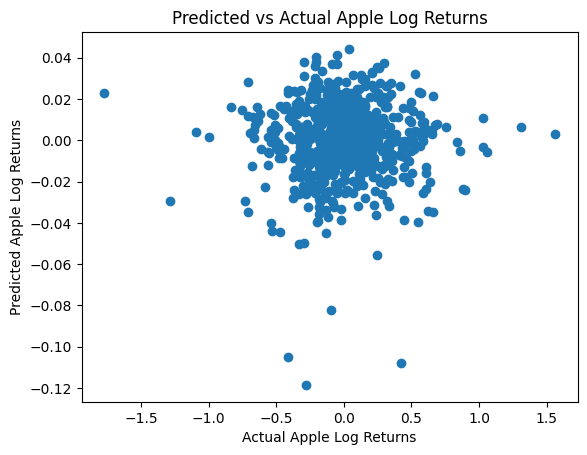

In [51]:
plt.figure()
plt.scatter(y_true_clean, y_pred_clean)
plt.xlabel("Actual Apple Log Returns")
plt.ylabel("Predicted Apple Log Returns")
plt.title("Predicted vs Actual Apple Log Returns")
plt.show()


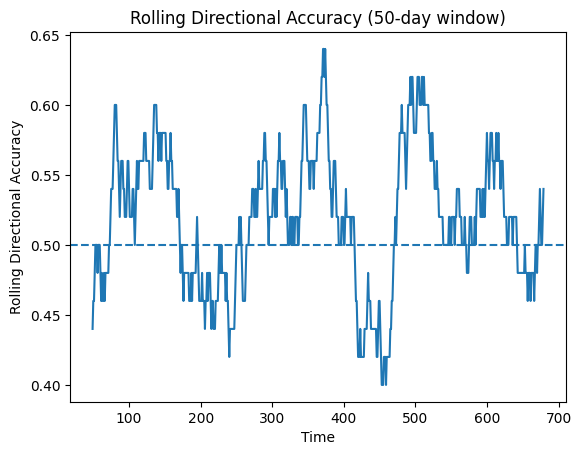

In [52]:
window = 50  # ~2 trading months

direction_correct = (
    np.sign(y_pred_clean) == np.sign(y_true_clean)
).astype(int)

rolling_accuracy = pd.Series(direction_correct).rolling(window).mean()

plt.figure()
plt.plot(rolling_accuracy)
plt.axhline(0.5, linestyle='--')
plt.xlabel("Time")
plt.ylabel("Rolling Directional Accuracy")
plt.title("Rolling Directional Accuracy (50-day window)")
plt.show()


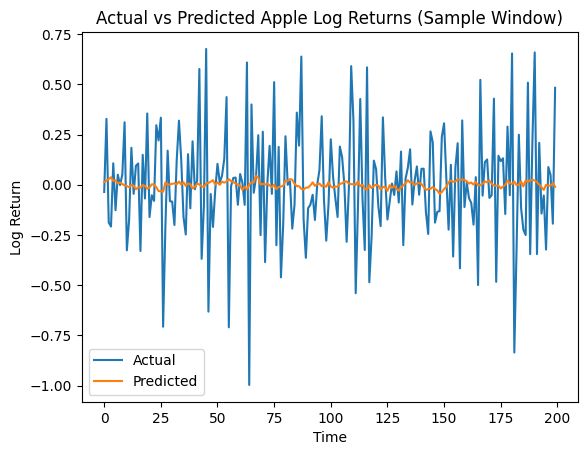

In [53]:
plt.figure()
plt.plot(y_true_clean[:200], label="Actual")
plt.plot(y_pred_clean[:200], label="Predicted")
plt.xlabel("Time")
plt.ylabel("Log Return")
plt.title("Actual vs Predicted Apple Log Returns (Sample Window)")
plt.legend()
plt.show()
